In [1]:
import numpy as np
from Bandits2 import Bandits
import matplotlib.pyplot as plt

In [2]:
def linucb_fairness40(self, ind=[], max_T=500, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=20, 
                    eps=[0.25], beta=[1], q_p=[0.2], q_w=[1], wid=[1], plots=[0, 1]):
    np.random.seed(seed)
    ret_ = [[], []]
    noise = np.mean(self.rewards) * noisef
    func = {0: self.LinUCB, 1: self.LinUCB_eps_greedy, 2: self.LinUCB_cost, 3: self.LinUCB_queue, -3: self.LinUCB_queue, 4: self.LinUCB_fairbounds}
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    hp = {0: [""], 1: eps, 2: beta, 3: q_p, -3: q_w, 4: wid}
    labe = {0: "", 1: ", ε=", 2: ", β=", 3: ", q_p=", -3: ", q_w=", 4: ", w="}
    param = {0: [{"T": max_T, "steps":steps}],
             1: [{"T": max_T, "steps":steps, "eps":ep} for ep in eps],
             2: [{"T": max_T, "steps":steps, "beta":b} for b in beta],
             3: [{"T": max_T, "steps":steps, "q_p":qp, "q_w":q_w[0]} for qp in q_p],
             -3: [{"T": max_T, "steps":steps, "q_p":q_p[0], "q_w":qw} for qw in q_w],
             4: [{"T": max_T, "steps":steps, "wid":w} for w in wid]}

    x = [int(np.floor(i * max_T / steps)) for i in range(1, steps+1)]
    y = {}
    con = {}
    freq = {}
    err = {}
    errcon = {}
    FSI = {}

    for i in ind:
        y[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        con[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        freq[i] = [np.zeros((self.C, self.K)) for l in range(len(param[i]))]
        err[i] = []
        errcon[i] = []
        FSI[i] = []
            
    assert len(np.unique(x)) == steps



    # Dependent variable (Regret)
    # Run algorithms
    for i in ind:
        for l in range(len(param[i])):
            for r in range(repeats):
                y[i][l][r] += np.array(func[i](la, delta, noise, fixed=[True, r], **param[i][l])[4])
                con[i][l][r] += self.run_logs[self.run_count-1]["Consistency"]
                ca = self.chosen_arms()

                # Update chosen arms
                for c in range(self.C):
                    freq[i][l][c] += ca[0][c]
    
            err[i].append(np.std(y[i][l], axis=0, ddof=1) / np.sqrt(repeats))
            errcon[i].append(np.std(con[i][l], axis=0, ddof=1) / np.sqrt(repeats))
    
            self.df = freq[i][l]/repeats
            print(func_name[i], hp[i][l], self.df)
            G = self.Gini_fairness()
            E = self.mix() + G
            FSI[i].append(E[0])
        

    for i in ind:
        for l in range(len(param[i])):
            ret_[0].append(np.sum(y[i][l], axis=0)/repeats)

    for i in ind:
        for l in range(len(param[i])):
            ret_[1].append(np.sum(con[i][l], axis=0)/repeats)

    return ret_

In [ ]:
def lf_400(K, d, C, p, alg=[0, 1, 2, 3], repe=10):
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    plot1y = []
    plot2y = []
    plot3y = []

    for seed in range(repe):
        A = Bandits(K=K, d=d, C=C, p=p, seed=seed)
        A.generate_context(max_T=100 * K * d**2 //9, repeats=10)
        print(f"seed={seed}a")
        a = A.rf_curve(alg=['eps-greedy', 'cost', 'queue', 'bounds'], max_T=100 * K * d**2 //9, la=0.16, delta=0.12, repeats=10, return_results=True)
        print(f"seed={seed}b")
        b = linucb_fairness40(A, ind=[1, 2, 3, 4], max_T=100 * K * d**2 //9, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=10, 
                    eps=[A.greedy_eps], beta=[A.cost_beta], q_p=[A.queue_q_p], q_w=[1], wid=[A.bounds_wid])
        print(A.greedy_eps, A.cost_beta, A.queue_q_p, A.bounds_wid)
        plot1y.append(a)
        plot2y.append(b[0])
        plot3y.append(b[1])

    # Plot 1
    plt.figure()
    plot1y = np.array(plot1y)
    for i in alg:
        x1 = np.mean(plot1y[:, i, 1, :], axis=0)
        xerr1 = np.std(plot1y[:, i, 1, :], axis=0, ddof=1) / np.sqrt(10)
        y1 = np.mean(plot1y[:, i, 0, :], axis=0)
        yerr1 = np.std(plot1y[:, i, 0, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x1, y1, xerr=xerr1, yerr=yerr1, label=func_name[i+1], linestyle='-', marker='o', markersize=2)

    plt.grid()
    plt.legend()
    plt.ylabel("Fairness-Spread")
    plt.xlabel("Regret")
    plt.title("Relationship between fairness measure and regret")
    plt.show()


    # Plot 2
    plt.figure()
    plot2y = np.array(plot2y)
    x2 = [int(np.floor(i * 100 * K * d**2 //9 / 25)) for i in range(1, 25+1)]
    for i in alg:
        y2 = np.mean(plot2y[:, i, :], axis=0)
        yerr2 = np.std(plot2y[:, i, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x2, y2, yerr=yerr2, label=f"{func_name[i+1]}", linestyle='-', marker='x', markersize=2)
        
    plt.legend()
    plt.grid()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cumulative Regret")
    plt.title("Relationship between # of iterations and cumulative regret")
    plt.show()

    # Plot 3
    plt.figure()
    plot3y = np.array(plot3y)
    x3 = [int(np.floor(i * 100 * K * d**2 //9 / 25)) for i in range(1, 25+1)]
    for i in alg:
        y3 = np.mean(plot3y[:, i, :], axis=0)
        yerr3 = np.std(plot3y[:, i, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x3, y3, yerr=yerr3, label=f"{func_name[i+1]}", linestyle='-', marker='x', markersize=2)
    plt.legend()
    plt.grid()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Consistency")
    plt.title("Relationship between # of iterations and consistency")
    plt.show()

    return None

## 1. Number of Arms

### 1.3 $K = 30$

seed=0a
0.14938015821857217
eps-greedy complete
0.14938015821857217
cost complete
0.14938015821857217
queue complete
0.14938015821857217
bounds complete
seed=0b
ε-greedy 1.264910675996945 [[0.0121     0.01056667 0.0552     0.01153333 0.01546667 0.01083333
  0.5042     0.0131     0.01113333 0.0172     0.01096667 0.01103333
  0.02043333 0.0105     0.01066667 0.0109     0.0108     0.01943333
  0.01103333 0.0108     0.01083333 0.01033333 0.01573333 0.01593333
  0.10513333 0.01043333 0.01073333 0.0105     0.0101     0.01236667]]
Diversity Cost 39.67122916900475 [[0.05083333 0.01183333 0.09686667 0.03683333 0.05623333 0.00743333
  0.11356667 0.0734     0.0017     0.0734     0.01216667 0.00473333
  0.08346667 0.00793333 0.01936667 0.00363333 0.00256667 0.05343333
  0.0021     0.00153333 0.002      0.00126667 0.0698     0.0508
  0.0975     0.00106667 0.00133333 0.00466667 0.0039     0.05463333]]
Queue 0.4850915137667034 [[0.016      0.016      0.04773333 0.016      0.016      0.016
  0.4540333

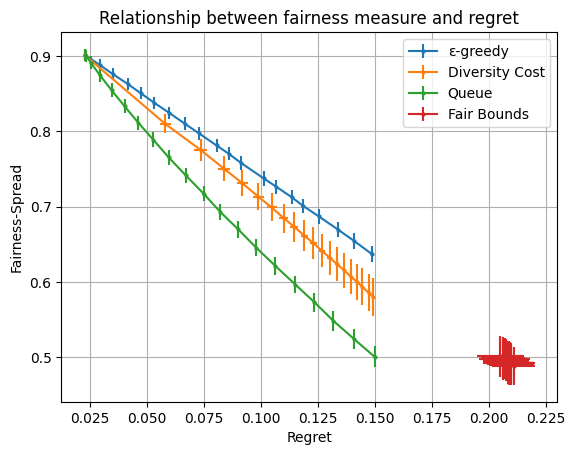

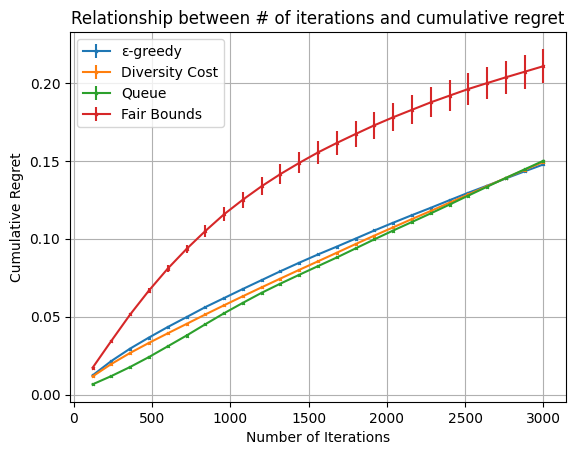

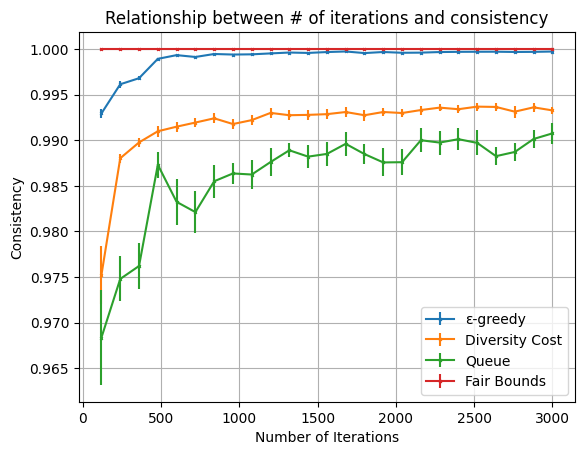

In [4]:
lf_400(30, 3, -1, 10, repe=10)

seed=0a
0.14938015821857217
eps-greedy complete
0.14938015821857217
cost complete
0.14938015821857217
queue complete
0.14938015821857217
bounds complete
seed=0b
ε-greedy 1.5583906779699983 [[0.02766667 0.02786667 0.08353333 0.0272     0.03593333 0.02746667
  0.51406667 0.0316     0.02613333 0.056      0.02586667 0.02946667
  0.0334     0.02693333 0.02686667]]
Diversity Cost 21.04334995678535 [[0.0734     0.0238     0.137      0.06026667 0.08606667 0.0188
  0.1588     0.10733333 0.00453333 0.10613333 0.03033333 0.01053333
  0.11933333 0.01873333 0.04493333]]
Queue 0.5995674749004598 [[0.03866667 0.03866667 0.0554     0.03866667 0.03866667 0.03426667
  0.4512     0.03866667 0.038      0.03906667 0.03853333 0.0344
  0.03886667 0.03833333 0.0386    ]]
Fair Bounds 0.12333833118061563 [[0.0316     0.03153333 0.08213333 0.03253333 0.02986667 0.02753333
  0.49893333 0.034      0.02733333 0.0302     0.03553333 0.03626667
  0.04193333 0.03133333 0.02926667]]
1.5583906779699983 21.04334995678535 

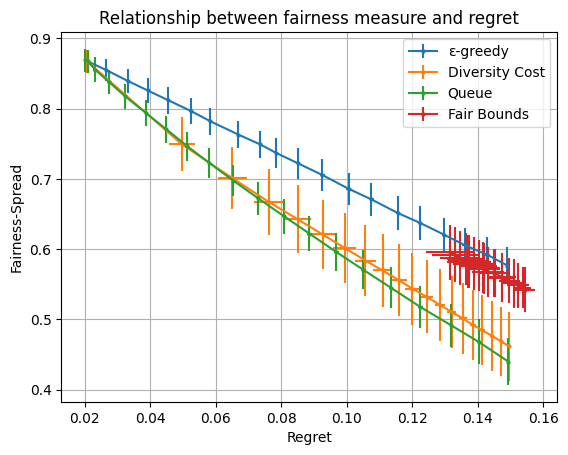

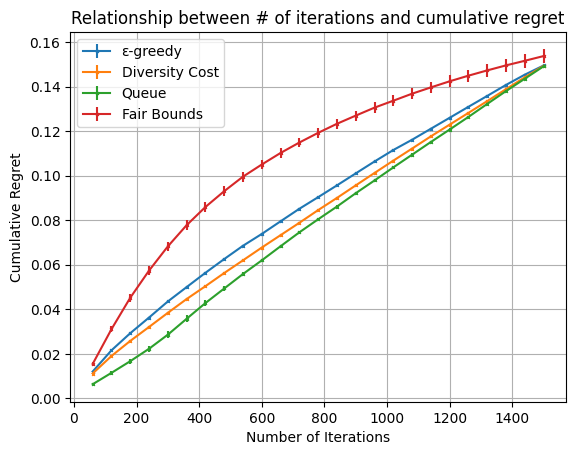

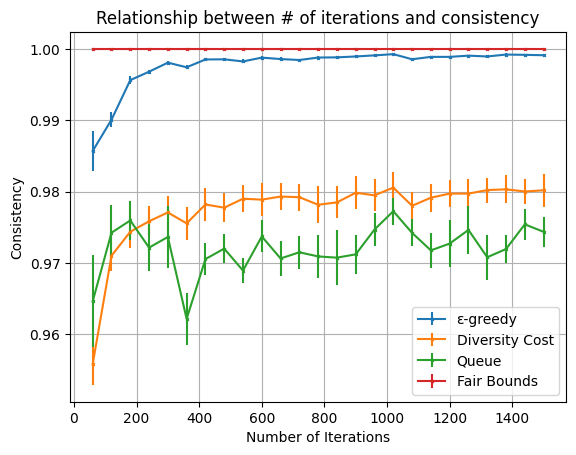

In [5]:
lf_400(15, 3, -1, 10, repe=10)